# Tutorial 2: Coordinates and orbits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table
import urllib.request
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u

%matplotlib inline

In this tutorial we will look at the orbits of the Milky Way dwarf spheroidal galaxies. Many of these had their proper motions robustly measured for the first time (Helmi et al. 2018, Simon 2018, Fritz et al. 2018, Massari et al. 2018). This illustrates conversion from observed coordinates (equatorial coordinates, proper motions, distances and radial velocities) to more physical coordinates with respect to the Galaxy. We will also use galpy's orbit functionality.

I have combined the Gaia proper motion measurements (from Fritz et al. 2018) with the McConnachie (2010) dwarf spheroidal galaxy catalogue (containing distances and radial velocities). It is available here: https://www.ast.cam.ac.uk/~jls/data/dwarf_spheroidal_data.fits . The table contains on-sky equatorial coordinates, distances (computed from distance moduli), radial velocities and proper motions. We have not provided uncertainties but in general these are significant.

In [2]:
reqst = urllib.request.urlretrieve(
    "https://www.ast.cam.ac.uk/~jls/data/dwarf_spheroidal_data.fits", 
    "dwarf_spheroidal_data.fits")
data = Table.read("dwarf_spheroidal_data.fits")
print(data)

satellite         ra         ...         pmra               pmdec       
                 deg         ...       mas / yr            mas / yr     
--------- ------------------ ... ------------------- -------------------
   Aqu II           338.4813 ...              -0.252               0.011
    Boo I            210.025 ... -0.5539999999999999              -1.111
   Boo II              209.5 ... -2.6860000000000004               -0.53
  Boo III              209.3 ...                 nan                 nan
 CanVen I 202.01458333333332 ...              -0.159              -0.067
CanVen II 194.29166666666663 ...              -0.342              -0.473
    Car I 100.40291666666668 ...               0.485               0.132
   Car II           114.1066 ...               1.867 0.08199999999999999
  Car III           114.6298 ...  3.0460000000000003               1.565
 ComBer I  186.7458333333333 ...               0.471              -1.716
      ...                ... ...                 ..

### Galactocentric coordinates
We use astropy coordinates to find the Galactocentric positions and velocities. First, we initialize a SkyCoord object. We can then transform to any frame (here Galactocentric). Note that the output coordinates come complete with a description of the assumed solar position and velocity.

In [3]:
skycoords = SkyCoord(ra=data['ra'],dec=data['dec'],
                     distance=data['distance'],
                     pm_ra_cosdec=data['pmra'],pm_dec=data['pmdec'],
                     radial_velocity=data['radial_velocity'])

In [4]:
galcen = skycoords.transform_to(Galactocentric)
print(galcen[0])

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (28.4708803, 53.12710278, -86.07288446)
 (v_x, v_y, v_z) in km / s
    (91.67239149, 231.76259785, 130.25851467)>


### Orbits
We now integrate orbits using galpy. We can either initialized the orbits using the SkyCoord objects.

In [5]:
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit
orbits = [Orbit(skycoords[ii]) for ii in range(len(skycoords))]

/Users/jls/anaconda/envs/saas_fee_py/lib/python3.7/site-packages/astropy/coordinates/baseframe.py:128: AstropyDeprecationWarning: The `representation` keyword/property name is deprecated in favor of `representation_type`
  'favor of `representation_type`', AstropyDeprecationWarning)



Or we can explicitly compute the required galpy quantities (with units) and then initialize explicitly. These differ slightly in their assumed solar position and velocity.

In [6]:
# Compute quantities needed by galpy
R = np.sqrt(galcen.x**2+galcen.y**2)
vR = (galcen.v_x*galcen.x+galcen.v_y*galcen.y)/R
vT = -(-galcen.v_x*galcen.y+galcen.v_y*galcen.x)/R
phi = np.arctan2(galcen.x,galcen.y)+np.pi/2.*u.rad

orbits2 = [Orbit(vxvv=[R[ii],vR[ii],vT[ii],
                       galcen.z[ii],galcen.v_z[ii],phi[ii]]) 
           for ii in range(len(skycoords))]

We integrate both sets of orbits forwards for 10 Gyr in the MWPotential2014

In [7]:
times = np.linspace(0.,10.,500)*u.Gyr
[o.integrate(t=times,pot=MWPotential2014) for o in orbits]
[o2.integrate(t=times,pot=MWPotential2014) for o2 in orbits2];

We can inspect the individual orbits (e.g. Coma Berenices). Note the very small difference between the two orbits due to the two different conventions.

ComBer I


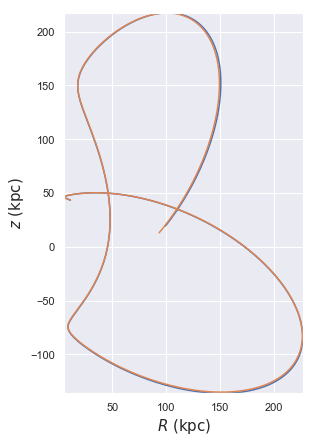

In [8]:
ii=9
plt.figure(figsize=[7.,7.])
print(data['satellite'][ii])
orbits2[ii].plot(gcf=True)
orbits[ii].plot(overplot=True,color=sns.color_palette()[1]);
plt.gca().set_aspect('equal')

Now we plot all orbits in 3d.

/Users/jls/anaconda/envs/saas_fee_py/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)

/Users/jls/anaconda/envs/saas_fee_py/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)



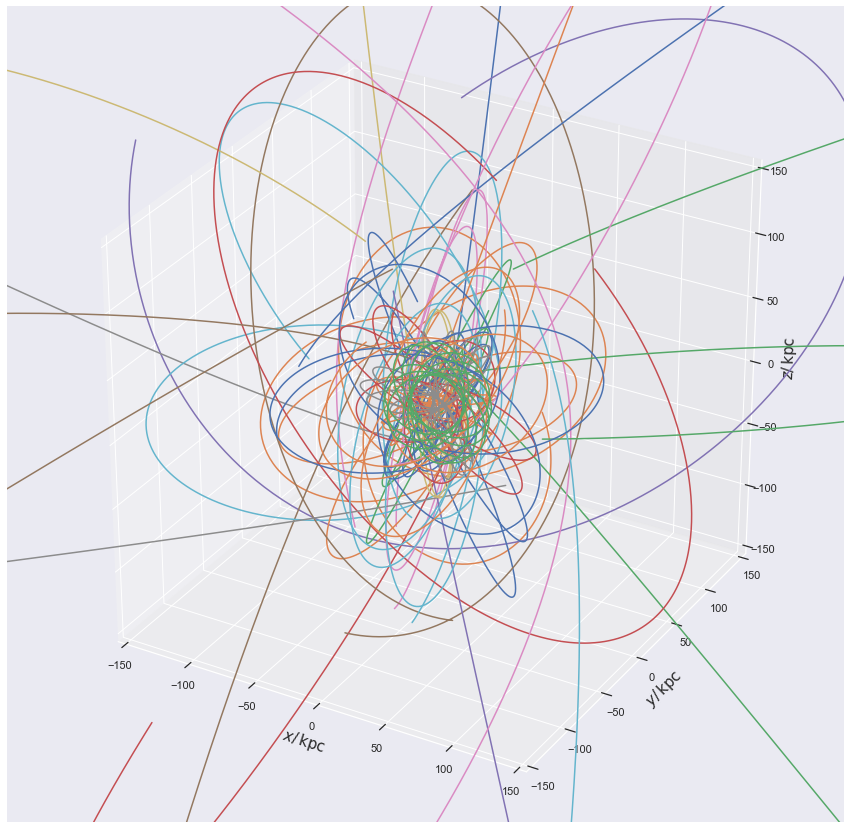

In [9]:
fig = plt.figure(figsize=[15.,15.])  
ax = fig.add_subplot(111, projection='3d') 

for ii in range(len(orbits)):
    orbits[ii].plot3d(overplot=True)
    
ax.set_xlim(-150.,150.)
ax.set_ylim(-150.,150.)
ax.set_zlim(-150.,150.)
ax.set_xlabel(r'$x/\,\mathrm{kpc}$')
ax.set_ylabel(r'$y/\,\mathrm{kpc}$')
ax.set_zlabel(r'$z/\,\mathrm{kpc}$');

We can also inspect properties of the ensemble. Like the distribution of pericentric distances.

/Users/jls/anaconda/envs/saas_fee_py/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/Users/jls/anaconda/envs/saas_fee_py/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)

/Users/jls/anaconda/envs/saas_fee_py/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)



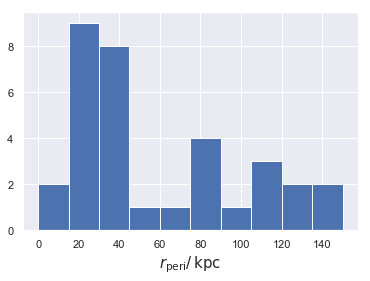

In [10]:
plt.hist([o.rperi() for o in orbits],range=[0.,150.]);
plt.xlabel(r'$r_\mathrm{peri}/\,\mathrm{kpc}$');

We have inspected the orbits of the dwarf spheroidal galaxies in the Milky Way. The next things to do would be to look at:

1. Varying the potential

2. Calculating the uncertainties (Monte Carlo sampling)

3. Inspecting distributions of orbital quantities and their correlations

(see Fritz et al. 2018, Helmi et al. 2018).